In [4]:
# install these libraries if you don't already have them
# !pip install facebook_scraper
# !pip install vaderSentiment
# !pip install openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections.abc import Iterable
from facebook_scraper import get_posts 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy.matcher import PhraseMatcher
import statsmodels.api as sm

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})

In [5]:
listposts = []

for post in get_posts('RameshgayanFernando', cookies="/Users/kelumrubasin/Desktop/MSC_DATA_SCIENCE/1_Social_Media_Analytics/Assignment_CIS7029/facebook_data/facebook.com_cookies.txt",
                      pages=1,
                      options={'comments': True}):
    listposts.append(post)
    
print('Number of posts: {}'.format(len(listposts)))   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: UserWarning: A low page limit (<=2) might return no results, try increasing the limit
  exec(code_obj, self.user_global_ns, self.user_ns)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/facebook_scraper/facebook_scraper.py:881: UserWarning: Facebook says 'Unsupported Browser'
  warnings.warn(f"Facebook says 'Unsupported Browser'")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dateparser/freshness_date_parser.py:76: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  now = self.get_local_tz().localize(now)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/dateparser/d

Number of posts: 1


In [53]:
columns = ['post_id', 
           'time',  
           'text', 
           'likes',
           'comments', 
           'shares', 
           'comments_full']

df_posts = pd.DataFrame(listposts)[columns]

In [54]:
analyzer = SentimentIntensityAnalyzer()

list_comments = []
for index, row in df_posts.iterrows():
    post_id = row['post_id']
    if isinstance(row['comments_full'], Iterable):
        for comment in row['comments_full']:
            dict_temp = {}
            dict_temp['post_id'] = post_id
            dict_temp['comment'] = comment['comment_text']
            dict_temp['sentiment'] = analyzer.polarity_scores(
                comment['comment_text'])['compound']
            list_comments.append(dict_temp)        

df_comments = pd.DataFrame(list_comments)

In [55]:
posts_sentiment = df_comments.groupby('post_id').mean()

df_posts = df_posts.join(posts_sentiment, on=['post_id'])

df_posts.drop(columns=['comments_full'], inplace=True)
df_posts.fillna(0.0, inplace=True)

with pd.ExcelWriter('../housenlandslk_review.xlsx') as writer:
    df_posts.to_excel(writer, sheet_name='posts_data', index_label='ID')
    df_comments.to_excel(writer, sheet_name='posts_comments', index_label='ID')
    

In [56]:
# Load data from exisiting files to save time
df_posts = pd.read_excel('../housenlandslk_review.xlsx', sheet_name='posts_data')
df_comments = pd.read_excel('../housenlandslk_review.xlsx', sheet_name='posts_comments')

In [57]:
# print out dataframe for posts 
df_posts.head()

,ID,post_id,time,text,likes,comments,shares,sentiment
0,0,5305747159544998,2022-07-16 15:28:14,HOUSE FOR SALE DEHIWALA COLOMBO SRI LANKA\n\nH...,59,39,54,0.146793
1,1,5247800718672976,2022-06-25 22:03:38,HOUSE FOR SALE IN KOHUWALA COLOMBO SRI LANKA\n...,45,82,21,0.000000
2,2,5243869132399468,2022-06-24 12:57:32,0,10,11,25,0.000000
3,3,5241136272672754,2022-06-23 13:53:49,HOUSE FOR SALE IN PELAWATTA COLOMBO SRI LANKA\...,40,2,21,0.000000
4,4,5235220369931011,2022-06-21 11:26:40,HOUSE FOR SALE IN BORALASGAMUWA COLOMBO SRI LA...,27,5,37,0.000000


In [58]:
# print out dataframe for comments 
df_comments.head()

,ID,post_id,comment,sentiment
0,0,5305747159544998,Price please,0.3182
1,1,5305747159544998,Price,0.0000
2,2,5305747159544998,Price pls,0.0772
3,3,5305747159544998,Price please,0.3182
4,4,5305747159544998,Price please,0.3182


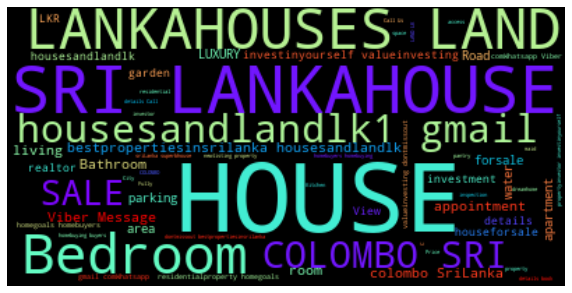

In [62]:
# merge all texts in posts
post_text = ' '.join(str(v) for v in df_posts['text'])
post_text = post_text.replace('\n', '') # remove blank lines characters

# update stopwords
stopwords = set(STOPWORDS)
stopwords.update(['https', 'gov', 'au', 'nsw', 's', 're', ' '])

# Generate a word cloud image
wordcloud = WordCloud(random_state=1, 
                      collocations=True, 
                      stopwords=stopwords,
                      max_words=60,
                      background_color='black',
                      colormap ='rainbow',
                      contour_color='steelblue').generate(post_text)

# Function to display word cloud img via matplotlib
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# plot world cloud    
plot_cloud(wordcloud)

In [71]:
# list of common products / services
products = ['train', 'bus', 'ferry', 'light rail', 'metro', 
            'road', 'bridge', 'westconnex', 'walk', 'cycling']

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Create the PhraseMatcher object. The tokenizer is the first argument. Use attr = 'LOWER' to make consistent capitalization
matcher = PhraseMatcher(nlp.vocab, attr='LOWER')

# Only run nlp.make_doc to speed things up
prod_tokens = [nlp.make_doc(text) for text in products]

# Add the item patterns to the matcher
matcher.add("TfNSWProducts", prod_tokens)